In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing required Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import re
import time
import random
import imageio
import glob
from numpy import array
import librosa

Path of training data

In [ ]:
musicTrainDataPath = 'drive/MyDrive/Data/speech_music_classification/train/music'
speechTrainDataPath = 'drive/MyDrive/Data/speech_music_classification/train/speech'

In [ ]:
musicTrainData = glob.glob(musicTrainDataPath+ '/*.wav')
speechTrainData = glob.glob(speechTrainDataPath+ '/*.wav')
print(len(musicTrainData))
print(len(speechTrainData))

40
40


Spectrogram Function

In [ ]:
F = np.zeros((64,400), np.complex64)
def spectrogram(x, windowLength=400, hopLength=160, n_fft=256):
    for k in range(64):
      for n in range(0, 400):
          F[k,n] =  np.exp(-2j *k * n * np.pi/400)
    spec = np.zeros(((1 + np.int(np.floor((len(x) - windowLength) / float(hopLength)))), 64), np.complex64)
    for i in range((1 + np.int(np.floor((len(x) - windowLength) / float(hopLength))))):
      spec[i] = F @ (x[i * hopLength: i * hopLength + windowLength] * np.hamming(windowLength))
    spec = np.log(np.abs(spec[:, :64 // 2])+1e-8)                     
    return spec

In [ ]:
musicFrames = [] #Could change the number of frames??
for i in range(0, len(musicTrainData)):
  data, sampleRate = librosa.load(musicTrainData[i],sr = None)#Can change sampling rate
  musicFrames.extend(spectrogram(data))
musicFrames = np.array(musicFrames)
# musicFrames = musicFrames
musicFrames.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

(119920, 32)

In [ ]:
speechFrames = []
for i in range(0, len(speechTrainData)):
  data, sampleRate = librosa.load(speechTrainData[i],sr = None)
  speechFrames.extend(spectrogram(data))
speechFrames = np.array(speechFrames)
speechFrames.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

(119920, 32)

Initilaizing K clusters 

In [ ]:
class KMean:
  def __init__(self, numberOfClusters , numberOfIteration = 1000):
    self.numberOfClusters = numberOfClusters
    self.numberOfIteration = numberOfIteration
    self.centers = None  



  def KMeanfit(self, musicFrames):
    it=0
    self.centers = musicFrames[np.random.choice(np.arange(len(musicFrames)), size = self.numberOfClusters)]
    for _ in range(self.numberOfIteration):
      it+=1
      distanceMatrix = np.zeros((len(musicFrames), self.numberOfClusters))
      for i in  range(self.numberOfClusters):
        distanceMatrix[:, i] = self.euclideanDistance(musicFrames, self.centers[i]) 
      clusterAssignment = distanceMatrix.argmin(axis=1)
      newCenters = np.zeros_like(self.centers)
      for i in range(self.numberOfClusters):
        newCenters[i] = np.mean(musicFrames[clusterAssignment == i], axis=0)
      if np.allclose(newCenters, self.centers):
        self.centers = newCenters
        break
      self.centers = newCenters
    print(it)
    return self.centers
    print(it)
          
  def KMeanpredict(self, musicFrames):
    distanceMatrix = np.zeros((len(musicFrames), self.numberOfClusters))
    for i in range(self.numberOfClusters):
      distanceMatrix[:, i] = self.euclideanDistance(musicFrames, self.centers[i]) 
    clusterAssignment = distanceMatrix.argmin(axis=1)
    return clusterAssignment

  def euclideanDistance(self, pointA, pointB):
    return np.sqrt(np.sum((pointA - pointB) ** 2, axis=1))
    

GMM Function

In [ ]:
# numberOfMixtures = 2
# totalIterations = 50
# global alpha # = np.ones(numberOfMixtures) / numberOfMixtures
# logLikeliHoodList = []
# mv = KMeanfit(musicFrames)
# covariance = np.zeros((numberOfMixtures, musicFrames.shape[1], musicFrames.shape[1]))
# clusters = [f"cluster{i}" for i in range(numberOfMixtures)]
# alpha = np.ones(numberOfMixtures) / numberOfMixtures
class GMM:
  def __init__(self, numberOfMixtures, clusters = None, totalIterations = 1000, covarianceFlag = True):
    self.numberOfMixtures = numberOfMixtures
    self.totalIterations = totalIterations
    self.logLikeliHoodList = []
    self.covarianceFlag = covarianceFlag
    if clusters == None:
      temp = []
      for i in range(0, self.numberOfMixtures):
        temp.append("cluster" + str(i))
      self.cluster = temp
      # self.clusters = [f"cluster{index}" for index in range(self.numberOfMixtures)]
    else:
      self.clusters = clusters
    self.alpha = np.ones(numberOfMixtures) / numberOfMixtures
    
    

  def multivariateNormal(self, musicFrames, mean, covariance):
    a = multivariate_normal(mean=mean, cov=covariance)
    return a.pdf(musicFrames)


  def logLikelihood(self, musicFrames):
    # alpha = np.ones(numberOfMixtures) / numberOfMixtures
    p = np.zeros((len(musicFrames), self.numberOfMixtures))
    for i in range(self.numberOfMixtures):
      p[:, i] = self.alpha[i] * multivariate_normal(self.mv[i], self.covariance[i]).pdf(musicFrames)
      # probs[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
      # p.append([multivariate_normal(mv[k], covariance[k]).pdf(musicFrames[n]) for k in range(numberOfMixtures)])
    likeliHood = np.sum(np.log(p.sum(axis=1)))
    return likeliHood


  def GMMfit(self, musicFrames):
    flag = 0
    # alpha = np.ones(numberOfMixtures) / numberOfMixtures
    KMeanObject = KMean(numberOfClusters = self.numberOfMixtures)
    self.mv = KMeanObject.KMeanfit(musicFrames)
    self.covariance = np.zeros((self.numberOfMixtures, musicFrames.shape[1], musicFrames.shape[1]))
    predictionKMean = KMeanObject.KMeanpredict(musicFrames)
    for i in range(self.numberOfMixtures):
      self.covariance[i] = np.cov(musicFrames[predictionKMean == i].T)
    for _ in range(self.totalIterations):


      self.temp = np.zeros((len(musicFrames), self.numberOfMixtures)) 
      # print(_)
      for i in range(self.numberOfMixtures):
        self.temp[:,i] = self.alpha[i] * (multivariate_normal(self.mv[i], self.covariance[i]).pdf(musicFrames))
      self.logLikeliHoodList.append(np.sum(np.log(self.temp.sum(axis=1))))
      self.temp = self.temp / self.temp.sum(axis=1)[:, None]
      # self.logLikeliHoodList.append(np.sum(np.log(self.temp.sum(axis=1))))



      tmv = np.zeros_like(self.mv)
      for i in range(self.numberOfMixtures):
        tmv[i] = np.multiply(self.temp[:, i][:, None], musicFrames).sum(axis=0) / self.temp[: , i].sum()
      omv = self.mv
      self.mv = tmv
      covarinaceOld = self.covariance
      
      if(self.covarianceFlag == True):
        diagonalCovarinace = ((np.dot((self.temp.T), (musicFrames * musicFrames)) / self.temp.sum(axis=0)[:, None]) 
                              - 2 
                              * (self.mv * np.dot(self.temp.T, musicFrames) / self.temp.sum(axis=0)[:, None]) 
                              + (self.mv * self.mv) + 1e-6)
        self.covariance = [np.diag(c) for c in diagonalCovarinace]
      else:
        covarinaceNew = np.zeros_like(self.covariance)
        for i in range(self.numberOfMixtures):
          covarinaceNew[i] = np.dot(self.temp[:, i] * (musicFrames - self.mv[i]).T, (musicFrames - self.mv[i])) / self.temp[:, i].sum()    
          covarinaceNew[i].flat[::musicFrames.shape[1] + 1] += 1e-6
          self.covariance[i] = covarinaceNew[i]

      alphaOld = self.alpha
      self.alpha = self.temp.mean(axis=0)

      if np.allclose(self.alpha, alphaOld, rtol=1e-3, atol = 1e-3) and \
        np.allclose(self.covariance, covarinaceOld, rtol=1e-3, atol = 1e-3) and\
        np.allclose(self.mv, omv, rtol=1e-3, atol = 1e-3):
        flag += 1
        if(flag == 3):
          print("Converged at, ", _)
          break

  def GMMpredict(self, musicFrames):
    pos = []
    result = []
    for n in range(len(musicFrames)):
      pos.append([multivariate_normal(self.mv[k], self.covariance[k]).pdf(musicFrames[n]) for k in range(self.numberOfMixtures)])  
    for p in pos:
      result.append(self.clusters[p.index(max(p))])
    return result
  
  

Two Mixture Model of Music Data with Diagonal Covariance

In [ ]:
DiagonalCovariance2musicModel  = GMM(2)
DiagonalCovariance2musicModel.GMMfit(musicFrames)


23
Converged at,  11


Text(0, 0.5, 'Log likelihood')

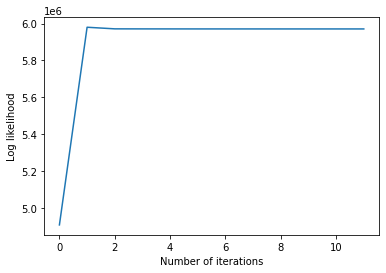

In [ ]:
plt.plot(-np.array(DiagonalCovariance2musicModel.logLikeliHoodList))
plt.xlabel("Number of iterations")
plt.ylabel("Log likelihood")

Two Mixture Model of Speech Data with Diagonal Covariance

In [ ]:
DiagonalCovariance2SpeechModel = GMM(2)
DiagonalCovariance2SpeechModel.GMMfit(speechFrames)

16
Converged at,  10


Text(0, 0.5, 'Log likelihood')

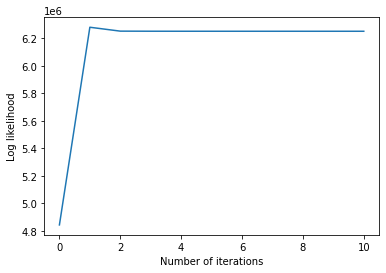

In [ ]:
plt.plot(-np.array(DiagonalCovariance2SpeechModel.logLikeliHoodList))
plt.xlabel("Number of iterations")
plt.ylabel("Log likelihood")


Two Mixture Model of Music Data with Full Covariance

In [ ]:
fullCovariance2MusicModel= GMM(2, covarianceFlag = False)
fullCovariance2MusicModel.GMMfit(musicFrames)

28
Converged at,  33


Text(0, 0.5, 'Log_likelihood')

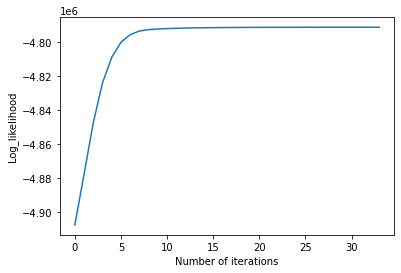

In [ ]:
plt.plot(fullCovariance2MusicModel.logLikeliHoodList)
plt.xlabel("Number of iterations")
plt.ylabel("Log_likelihood")


Two Mixture Model of Speech Data with full Covariance

In [ ]:
fullCovariance2SpeechModel= GMM(2, covarianceFlag = False)
fullCovariance2SpeechModel.GMMfit(speechFrames)

16
Converged at,  66


Text(0, 0.5, 'Log_likelihood')

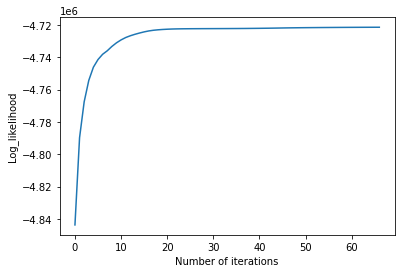

In [ ]:
plt.plot(fullCovariance2SpeechModel.logLikeliHoodList)
plt.xlabel("Number of iterations")
plt.ylabel("Log_likelihood")

Five Mixture Model of Music Data with Diagonal Covariance

In [ ]:
DiagonalCovariance5MusicModel = GMM(numberOfMixtures = 5)
DiagonalCovariance5MusicModel.GMMfit(musicFrames)

55
Converged at,  22


Text(0, 0.5, 'Loglikelihood')

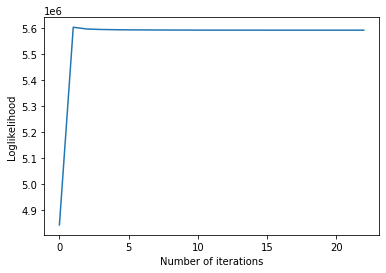

In [ ]:
plt.plot(-np.array(DiagonalCovariance5MusicModel.logLikeliHoodList))
plt.xlabel("Number of iterations")
plt.ylabel("Loglikelihood")


Five Mixture Model of Speech Data with Diagonal Covariance

In [ ]:
DiagonalCovariance5SpeechModel = GMM(5)
DiagonalCovariance5SpeechModel.GMMfit(speechFrames)

86
Converged at,  52


Text(0, 0.5, 'Loglikelihood')

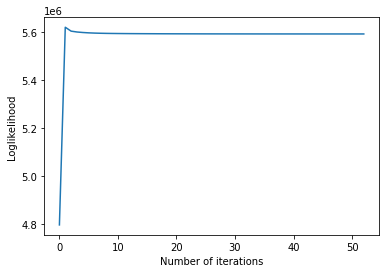

In [ ]:
plt.plot(-np.array(DiagonalCovariance5SpeechModel.logLikeliHoodList))
plt.xlabel("Number of iterations")
plt.ylabel("Loglikelihood")

Five Mixture Model of Music Data with Full Covariance

In [ ]:
fullCovariance5MusicModel = GMM(5, covarianceFlag = False)
fullCovariance5MusicModel.GMMfit(musicFrames)

71
Converged at,  141


Text(0, 0.5, 'Log_likelihood')

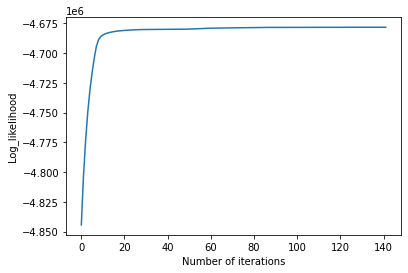

In [ ]:
plt.plot(fullCovariance5MusicModel.logLikeliHoodList)
plt.xlabel("Number of iterations")
plt.ylabel("Log_likelihood")

Five Mixture Model of Speech Data with Full Covariance

In [ ]:
fullCovariance5SpeechModel = GMM(5, covarianceFlag = False)
fullCovariance5SpeechModel.GMMfit(speechFrames)

143
Converged at,  167


Text(0, 0.5, 'Log_likelihood')

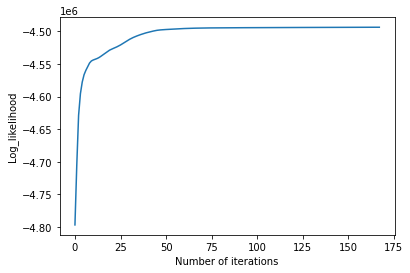

In [ ]:
plt.plot(fullCovariance5SpeechModel.logLikeliHoodList)
plt.xlabel("Number of iterations")
plt.ylabel("Log_likelihood")

Loading Testing Data

In [ ]:
path = 'drive/MyDrive/Data/speech_music_classification/test/'
test = []

files = glob.glob(path + '*.wav')

for i in files:
    if(i.split('/')[-1].split('_')[0] == 'music'):
      test.append(0)
    else:
      test.append(1)
print(test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Making Prediction on Testing Data using Five Mixture Model of Speech & Music with Diagonal Covariance

In [ ]:
prediction = []
for i in files:
    testData, sampleRate = librosa.load(i, sr=None)
    testDataSpectogram = spectrogram(testData)

    TestSpeechLogLikelihood = DiagonalCovariance5SpeechModel.logLikelihood(testDataSpectogram)
    TestMusicLogLikelihood = DiagonalCovariance5MusicModel.logLikelihood(testDataSpectogram)
    if(TestMusicLogLikelihood > TestSpeechLogLikelihood):
      prediction.append(0)
    else:
      prediction.append(1)
test = np.array(test)
prediction = np.array(prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Calculating Accuracy

In [ ]:
count = 0
for i in range(0, len(test)):
  if(prediction[i] == test[i]):
    count += 1
print("Accuracy : ", (count/len(files)*100))

Accuracy :  95.83333333333334




*   The error rate decreases when we will increase the number of mixtures.


